### Convert captions to lists of token indices

In [1]:
import os
import re
import tqdm
import json
import time
%pylab inline

THRESHOLD = 5

j_train = json.loads(open('/home/paperspace/data/ms_coco/captions_train2014.json').read())
j_val = json.loads(open('/home/paperspace/data/ms_coco/captions_val2014.json').read())
train = {d['caption']: d['image_id'] for d in j_train['annotations']}
val = {d['caption']: d['image_id'] for d in j_val['annotations']}

print('filtering non-alphabetic characters'); time.sleep(.2)
for d in (train, val):
    for k in tqdm.tqdm(d.keys()):
        f = re.sub('[^a-z \h]', '', k.lower())
        d[f] = d.pop(k)

print('splitting on spaces and hashing'); time.sleep(.2)
total = train.keys() + val.keys()
instances = {}
for caption in tqdm.tqdm(total):
    for w in caption.split(' '):
        if w != '':
            try:
                instances[w] += 1
            except:
                instances[w] = 1

print('filtering stopwords')
words = sorted(instances.keys())
words_set = set(words)
#nltk_stopwords = set(w for w in open('stopwords.txt').read().split('\n') if w != '')
go_words = set([w for (w, c) in instances.items() if c > THRESHOLD])
stop_words = words_set - go_words

words_to_inds = dict(zip(sorted(list(go_words)), range(len(go_words))))
inds_to_words = dict(zip(range(len(go_words)), sorted(list(go_words))))

words_to_inds['UNKNOWN'] = len(go_words)
inds_to_words[len(go_words)] = 'UNKNOWN'


print('converting captions to indices'); time.sleep(.2)
for d in (train, val):
    for k in tqdm.tqdm(d.keys()):
        v = d.pop(k)
        split = k.split(' ')
        split_caption = []
        for w in split:
            if w != '':
                if w in stop_words:
                    w = 'UNKNOWN'
                split_caption.append(w)
                
        indices = [words_to_inds[w] for w in split_caption]
        try:
            d[v].append(indices)
        except:
            d[v] = []
            d[v].append(indices)

Populating the interactive namespace from numpy and matplotlib
filtering non-alphabetic characters


100%|██████████| 198162/198162 [00:00<00:00, 271636.39it/s]


splitting on spaces and hashing


100%|██████████| 597442/597442 [00:02<00:00, 270927.35it/s]


filtering stopwords
converting captions to indices


100%|██████████| 197755/197755 [00:01<00:00, 112946.52it/s]


### Find an appropriate maximum caption length

max length: 49
mean length: 10.485191868
median length: 10.0
standard deviation: 2.40983629941
percent of total captions with greater than 20 words: 0.61%

black night a blurry shot shows a tall fence that angles in a kind of UNKNOWN shape around what appears to be a parking area with a large building UNKNOWN it as a kid with a red helmet takes a fierce swing in the batting area inside the fence


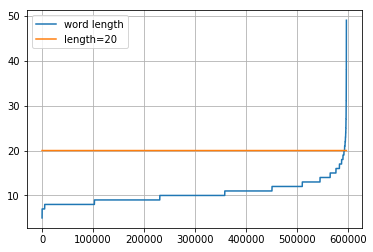

In [6]:
maxlen = 0
total = []
for d in (train, val):
    for k, v in d.items():
        for i, c in enumerate(v):
            size = len(c)
            total.append(size)
            if size > maxlen:
                maxlen = size
                max_id = k
                max_i = i
                max_d = d
                
total = array(total)
total.sort()
print('max length: '+str(maxlen)) 
print('mean length: '+str(total.mean()))
print('median length: '+str(median(total)))
print('standard deviation: '+str(total.std()))
print('percent of total captions with greater than 20 words: {:.2f}%'\
      .format(100 * (total > 20).sum() / float(total.size)))
plot(total, label='word length')
plot(arange(total.size), 20*ones(total.size), label='length=20')
legend(loc='best')
grid(which='both')
print('\n' + ' '.join([inds_to_words[i] for i in max_d[max_id][max_i]]))

### Truncate captions and append EOF token

In [7]:
n = len(words_to_inds)
words_to_inds['EOF'] = n
inds_to_words[n] = 'EOF'

target_length = 20

for d in (train, val):
    for k, v in d.items():
        n_captions = len(v)
        if n_captions < 7:
            d[k] += [[]]*(7-n_captions)
        for i, c in enumerate(d[k]):
            v[i] = c[:target_length-1]
            v[i] += [n]
            if len(v[i]) < target_length:
                v[i] += [-1]*(target_length-len(v[i]))

### Save

In [11]:
output_dir = '/home/paperspace/data/ms_coco/preproc_vocab-{}_threshold-{}_length-{}'\
             .format(len(words_to_inds), THRESHOLD, target_length)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
with open(os.path.join(output_dir, 'train_captions.json'), 'w') as outfile:
    json.dump(train, outfile)
with open(os.path.join(output_dir, 'val_captions.json'), 'w') as outfile:
    json.dump(val, outfile)
with open(os.path.join(output_dir, 'words_to_inds.json'), 'w') as outfile:
    json.dump(words_to_inds, outfile)
with open(os.path.join(output_dir, 'inds_to_words.json'), 'w') as outfile:
    json.dump(inds_to_words, outfile)

In [13]:
ls /home/paperspace/data/ms_coco/preproc_vocab-9509_threshold-5_length-20/

inds_to_words.json  train_captions.json  val_captions.json  words_to_inds.json
